# Studies on solving Kakuro puzzle with Grover algorithm

Valter Uotila, PhD student, University of Helsinki

Note: if you run certain cells again without restarting the kernel, there might be unexpected behaviour and errors due to how the notebook handles the variables.

As the discussion in Classiq's channel showed, this problem has been somewhat confusing. If we read the problem definition very carefully, it does not describe in detail what kind of Grover algorithm application it should be. For example, saying ''You are not allowed to solve the puzzle manually'' seems to be meaning actual manual solving by the person. On the other hand, it could also mean that 

Not caring so much what the exact problem is, I developed various solutions to the challenge. First I represent the solution that I consider interesting in the sense how it encodes the variables and values. Instead of using a huge number of qubits, we really should design algorithms so that we can take advantage of the exponentially growing space of states. Hilbert space is large indeed and we should benefit from that. The downside of the first solution is the fact that it is not really the Grover's algorithm that solves the problem but Grover's algorithm rather reads quantumly encoded solution from the black box oracle circuit. This is in the line of the Grover's original idea but it is not so interesting. Now it depends on the problem definition if this is allowed or not. I developed the solution so that you can input any (there must be some corner cases that fail) Kakuro problem that the algorithm classically creates the oracle and Grover's algorithm ''reads'' the solution from the oracle.

The second solution follows the idea that is also represented in Qiskit documentation: [Solving Sudoku using Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html#5.-Solving-Sudoku-using-Grover's-Algorithm-). I believe that this is the idea that has been in the developers' minds while desining the Kakuro challenge. Unlike the previous solution, here the Grover's algorithm really solves the problem but the downside is the large qubit number and depth of the circuit.

I partly participate the competitions because they motivate me to study new topics efficiently, I also wanted to consider the third option which is based on very interesting and recent paper: [Grover Adaptive Search for Constrained Polynomial Binary Optimization](https://arxiv.org/abs/1912.04088).

## Transform integer variables into binary variables

Let us assume that we have $n$ variables $x_i$ for $i = 0, \ldots, n - 1$. To have consistent notation we start indexing from $0$. Now each of these variables has a value $0,1,2,3$. In order to express to problem using the binary variables, we define binary variables $x_{i, j}$ so that $i = 0, \ldots, n - 1$ and $j \in \left\{0,1,2,3 \right\}$. Thus we have $4n$ binary variables in the final model. The interpretation of the binary variables is simple: $x_{i,j} = 1$ if $x_i = j$. This enables us to encode integers into binary model.

## Solution proposal 1: Qubit and gate efficient approach

The first idea how to tackle the challenge is to assign a state for each binary variable $x_{i,j}$. In the end, if we measure $x_{i,j} = 1$, then we know that $x_i = j$. For example, the variable $x_{0,0}$ would correspond to the state $|0000\rangle$ in the case $n = 4$. Because the number of states grows exponentially, we would be able to represent large problems with small number of qubits. If we are able to tranform the constraint into Grover oracle which favours those states which corresponds to the solution of the problem, this would solve the problem. Anyway, constructing such oracle seems a complicated task.

For me this exercise shows an interesting and also confusing point about quantum oracles. Usually quantum oracles encode the problems that we are solving. Oracles are black-box. Because we are constructing something, which we are not supposed to know, we actually solve the problem before we even send it to the quantum computer. In that sense, the quantum computer is just a machine that we use to read the result from the oracle.

### Studying constraint types

Although the problem definition had some discussion online, I believe that we can divide the constaints into two classes. Because I want to be able to code the solution so that anyone without thinking anything simply inputs Kakuro constraints from the problem, I start by considering the example case from the problem definition:
$$
\begin{align}
x_0 \neq & x_1 &\quad x_0 \neq& x_2 \\
x_1 \neq & x_3 &\quad x_2 \neq& x_3 \\
x_0 + x_1 =& 3 &\quad x_0 + x_2 =& 3 \\
x_2 + x_3 =& 4 &\quad x_1 + x_3 =& 4.
\end{align}
$$

#### Constraint type 1: inequality between two variables

Obviously the first class of constraints is
$$
\begin{align}
x_0 \neq & x_1 \\
x_2 \neq& x_3 \\
x_0 \neq& x_2 \\
x_1 \neq & x_3.
\end{align}
$$

Let's focus on the first constraint $x_0 \neq x_1$. In the binary variable format, this constraint means that if $x_{i,j} = 1$ then $x_{k,j} = 0$ for $i = 0, 1$, $k = 0, 1$, $i \neq k$ and for $j = 0,1,2,3$. In other words, if we flip the phase of the state corresponding the variable $x_{0,j}$ (meaning it is part of the solution), then we do not flip variable $x_{1,j}$. If we were to flip the both variables, then it would mean $x_0 = j = x_1$ which is not allowed.

This analysis shows that we have multiple options how to flip the states corresding the variables which are in the inequality constraints. As I described in the beginning, constructing the oracle means that we solve the problem in some sense.

So we proceed so that we initially create all the possible correct circuits for the constraint $x_0 \neq x_1$. Then we proceed to the next constraint $x_2 \neq x_3$ and append the possible options to the circuits produced in the previous step. At each appending phase, we check if some of the previous constraints are violeted. If a constraint is violeted, we drop the circuit from the process. Finally, we are left with Grover oracles that produce the correct solution to the problem.

#### Constraint type 2: sum of variables with equality to constant 

Clearly the second class of constraints is
$$
\begin{align}
x_0 + x_1 =& 3 \\
x_2 + x_3 =& 4 \\
x_0 + x_2 =& 3 \\
x_1 + x_3 =& 4.
\end{align}
$$

Again, let's focus on the constraint $x_0 + x_1 = 3$. This means that we have two variables whose values sum up to three. We can divide this into multiple cases:

- $x_0 = 0$ and $x_1 = 3$
- $x_0 = 3$ and $x_1 = 0$
- $x_0 = 1$ and $x_1 = 2$
- $x_0 = 2$ and $x_1 = 1$

Luckily variables can hold numbers only up to three so maximum value that we can face on the right-hand side of the equality is $6$. Also, it is safe to assume that we do not sum more than three variables at the time. This reduces the number of combinations.

Let's study the case that we want to encode $x_0 = 0$ and $x_1 = 3$. This means that we want to set $x_{0,0} = 1$ and $x_{1,3} = 1$ as binary variables. If we have encoded some constraints before this constraint, flipping the states of these variables might violate some previous constraints. That allows us to drop certain oracles from the construction process. Now we are only left to concretely code this approach.

### Implementation

Since we are dealing with multiple circuits at the same time, it is easier to use Qiskit than Pennylane.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.standard_gates import MCXGate, XGate
import numpy as np
import copy

If we concentrate the actual problem, the constraints are 

$$
\begin{align}
x_0 &\neq x_1 &\quad x_0 &\neq x_2 &\quad x_1 &\neq x_3 \\
x_1 &\neq x_5 &\quad x_2 &\neq x_3 &\quad x_2 &\neq x_4 \\
x_3 &\neq x_4 &\quad x_3 &\neq x_5 &\quad x_4 &\neq x_6 \\
x_5 &\neq x_6 &&&& \\
x_0 + x_2 &= 5 &\quad x_1 + x_3 + x_5 &= 3 &\quad x_4 + x_6 &= 1 \\
x_2 + x_4 + x_3 &= 5 &\quad x_0 + x_1 &= 3 &\quad x_5 + x_6 &= 1.
\end{align}
$$

For four variables we have $4*4 = 16$ binary variables which requires $16$ states so we need exactly four query qubits in Grover's algorithm. For six variables we need five query qubits.

In [2]:
query_qubits = 4
# query_qubits = 5

inequality_constraints = [(0,1), (0,2), (1,3), (1,5), (2,3), (2,4), (3,4), (3,5), (4,6), (5,6)]
inequality_constraints_test = [(0,1), (2,3), (1,3), (0,2)]

sum_equality_constraints = [{'variables': [0, 2], 'sum': 5}, {'variables': [1, 3, 5], 'sum': 3}, {'variables': [4, 6], 'sum': 1}, {'variables': [2, 3, 4], 'sum': 5}, {'variables': [0, 1], 'sum': 3}, {'variables': [5, 6], 'sum': 1}]
sum_equality_constraints_test = [{'variables': [0, 1], 'sum': 3}, {'variables': [2, 3], 'sum': 4}, {'variables': [0, 2], 'sum': 3}, {'variables': [1, 3], 'sum': 4}]

The following injective function maps the binary variables $x_{i,j}$ to integers whose binary representations correspond to states. We return the binary representation as a list since we will need to access each element in the representation later.

In [3]:
def variables_to_states(i,j):
    int_repr = 4*i + j
    bin_repr = np.binary_repr(int_repr)
    return '0'*(query_qubits - len(bin_repr)) + bin_repr

def state_to_variables(state):
    decimal = int(state, 2)
    j = decimal % 4
    i = int(np.floor(decimal/4))
    return (i, j)

In [4]:
# Encodes if x_3 = 2 i.e. x_3 = 2 is True if |1110> is True after measurement 
print(variables_to_states(3,2))
print(state_to_variables(variables_to_states(3,2)))

1110
(3, 2)


We proceed with the following idea: Every constraint induces options how to flip phases. Whatever we inlcude in the circuit, we need to exclude something. Consider the example if $x_{0,1} = 1$ then $x_{1,1} = 0$. When we include the gate that encodes the solution $x_{0,1} = 1$, then we cannot use the gate encoding $x_{1,1} = 1$ at any part of the circuit later. This process reduces the correct oracles.

In [5]:
# It appears that Qiskit supports very badly simulations on circuits that have been constructed separately
# Thus we just store the control qubit information and compose the circuit when we compose the Grover's algorithm
def compose_phase_flip_gate(i, j, circuit):
    ctrl = variables_to_states(i,j)
    circuit.add(ctrl)
    return circuit

def expand_inequality_oracles(x, y, oracles):
    new_oracles = []
    for oracle in oracles:
        for j in range(4):
            oracle_copy = copy.deepcopy(oracle)
            bin_table = oracle_copy['bin_table']
            if bin_table[x][j] != -1 and bin_table[y][j] != 1:
                bin_table[x][j] = 1
                for k in range(4):
                    if k != j:
                        bin_table[x][k] = -1
                bin_table[y][j] = -1
                circuit = oracle_copy['circuit']
                compose_phase_flip_gate(x, j, circuit)
                new_oracles.append(oracle_copy)
    return new_oracles


def initialize_oracles(x, y, oracles):
    for j in range(4):
        circuit = compose_phase_flip_gate(x, j, set())
        bin_table = np.zeros(shape=(query_qubits, 4))
        bin_table[x][j] = 1
        for k in range(4):
            if k != j:
                bin_table[x][k] = -1
        bin_table[y][j] = -1
        oracles.append({'circuit': circuit, 'bin_table' : bin_table })
    return oracles

    
def create_inequality_oracles(constraints):
    oracles = []
    x = constraints[0][0]
    y = constraints[0][1]
    oracles = initialize_oracles(x, y, oracles)
    oracles = initialize_oracles(y, x, oracles)
    
    for constraint in constraints[1:]:
        x = constraint[0]
        y = constraint[1]
        oracles = expand_inequality_oracles(x, y, oracles)
        oracles = expand_inequality_oracles(y, x, oracles)
    return oracles

In [6]:
oracles = create_inequality_oracles(inequality_constraints_test)
print(len(oracles))

168


The following function calculates how many different ways we can sum two or three variables so that we obtained the given sum.

In [7]:
def sum_options(constraint):
    variables = constraint['variables']
    sum_value = constraint['sum']
    result = []
    
    if len(variables) == 2:
        for i in range(4):
            if sum_value - i < 4 and sum_value - i > -1:
                result.append((i, sum_value - i))
    elif len(variables) == 3:
        for i in range(4):
            if sum_value - i < 4 and sum_value - i > -1:
                temp_options = sum_options({'variables': [0, 1], 'sum': i})
                for o in temp_options:
                    result.append((o[0], o[1], sum_value - i))
    return result

We then update the binary variable tables and the corresponding circuits based on the different combinations that summing creates.

In [8]:
def limit_oracles_based_on_sum_constraints(sums, constraint, oracles):
    correct_oracles = []
    variables = constraint['variables']
    for oracle in oracles:
        for option in sums:
            bin_table = oracle['bin_table']
            if all([bin_table[variables[k]][option[k]] == 1 for k in range(len(variables))]):
                correct_oracles.append(oracle)
    return correct_oracles
    

def build_sum_oracle(constraint, oracles):
    sums = sum_options(constraint)
    oracles = limit_oracles_based_on_sum_constraints(sums, constraint, oracles)
    return oracles

In [9]:
for constraint in sum_equality_constraints_test:
    oracles = build_sum_oracle(constraint, oracles)

In [10]:
def remove_duplicates(oracles):
    new_oracles = [oracles[0]]
    for oracle in oracles[1:]:
        if not any([np.array_equal(oracle['bin_table'], oracle2['bin_table']) for oracle2 in new_oracles]):
            new_oracles.append(oracle)
    return new_oracles

In [11]:
oracles = remove_duplicates(oracles)
print(oracles)
for b in oracles[0]['circuit']:
    print(state_to_variables(b))

[{'circuit': {'1011', '0111', '0000', '1101'}, 'bin_table': array([[ 1., -1., -1., -1.],
       [-1., -1., -1.,  1.],
       [-1., -1., -1.,  1.],
       [-1.,  1., -1., -1.]])}, {'circuit': {'1111', '1001', '0101', '0010'}, 'bin_table': array([[-1., -1.,  1., -1.],
       [-1.,  1., -1., -1.],
       [-1.,  1., -1., -1.],
       [-1., -1., -1.,  1.]])}]
(2, 3)
(1, 3)
(0, 0)
(3, 1)


### Implement Grover search

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram

In [33]:
def initialize_s(qc, qubits):
    # Hadamard transform
    qc.x(qubits[-1])
    qc.h(qubits)
    return qc

In [34]:
def compose_grover_oracle(qc, qubits, ctrl_char):
    not_indices = []
    qc.barrier()
    for i, b in enumerate(ctrl_char):
        if b == '0':
            qc.x(len(qubits) - 2 - i)
            not_indices.append(len(qubits) - 2 - i)
            
    qc.mcx(list(qubits[:-1]), len(qubits) - 1)
    
    for i in not_indices:
        qc.x(i)
    return qc

In [35]:
def diffusion(qc, qubits):
    qc.barrier()
    qc.h(qubits)
    qc.x(qubits[:-1])
    qc.mcx(list(qubits[:-1]), len(qubits) - 1)
    qc.x(qubits[:-1])
    qc.h(qubits)
    return qc

In [36]:
final_circuits = []

for oracle in oracles:
    grover_circuit = QuantumCircuit(query_qubits + 1, query_qubits)
    grover_circuit = initialize_s(grover_circuit, range(query_qubits + 1))
    
    for ctrl_char in oracle['circuit']:
        grover_circuit = compose_grover_oracle(grover_circuit, range(query_qubits + 1), ctrl_char)

    grover_circuit = diffusion(grover_circuit, range(query_qubits + 1))
    final_circuits.append(grover_circuit)

In [37]:
final_circuits[0].draw()

┌───┐      ░                 ░                 ░ ┌───┐     ┌───┐ ░      »
q_0: ┤ H ├──────░────────■────────░────────■────────░─┤ X ├──■──┤ X ├─░──────»
     ├───┤      ░        │        ░        │        ░ ├───┤  │  ├───┤ ░ ┌───┐»
q_1: ┤ H ├──────░────────■────────░────────■────────░─┤ X ├──■──┤ X ├─░─┤ X ├»
     ├───┤      ░ ┌───┐  │  ┌───┐ ░        │        ░ ├───┤  │  ├───┤ ░ └───┘»
q_2: ┤ H ├──────░─┤ X ├──■──┤ X ├─░────────■────────░─┤ X ├──■──┤ X ├─░──────»
     ├───┤      ░ └───┘  │  └───┘ ░ ┌───┐  │  ┌───┐ ░ ├───┤  │  ├───┤ ░      »
q_3: ┤ H ├──────░────────■────────░─┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─░──────»
     ├───┤┌───┐ ░      ┌─┴─┐      ░ └───┘┌─┴─┐└───┘ ░ └───┘┌─┴─┐└───┘ ░      »
q_4: ┤ X ├┤ H ├─░──────┤ X ├──────░──────┤ X ├──────░──────┤ X ├──────░──────»
     └───┘└───┘ ░      └───┘      ░      └───┘      ░      └───┘      ░      »
c: 4/════════════════════════════════════════════════════════════════════════»
                                                                             »
«                ░ ┌───┐┌───┐     ┌───┐┌───┐
«q_0: ──■────────░─┤ H ├┤ X ├──■──┤ X ├┤ H ├
«       │  ┌───┐ ░ ├───┤├───┤  │  ├───┤├───┤
«q_1: ──■──┤ X ├─░─┤ H ├┤ X ├──■──┤ X ├┤ H ├
«       │  └───┘ ░ ├───┤├───┤  │  ├───┤├───┤
«q_2: ──■────────░─┤ H ├┤ X ├──■──┤ X ├┤ H ├
«       │        ░ ├───┤├───┤  │  ├───┤├───┤
«q_3: ──■────────░─┤ H ├┤ X ├──■──┤ X ├┤ H ├
«     ┌─┴─┐      ░ ├───┤└───┘┌─┴─┐├───┤└───┘
«q_4: ┤ X ├──────░─┤ H ├─────┤ X ├┤ H ├─────
«     └───┘      ░ └───┘     └───┘└───┘     
«c: 4/══════════════════════════════════════
«

In [20]:
solution_counts = []
for grover_circuit in final_circuits:
    grover_circuit.measure(range(query_qubits), range(query_qubits))
    aer_sim = Aer.get_backend('aer_simulator', )
    qobj = assemble(grover_circuit)
    result = aer_sim.run(qobj, shots=100000).result()
    counts = result.get_counts()
    solution_counts.append(counts)
    print('fdasfasd')
    #plot_histogram(counts)

fdasfasd
fdasfasd


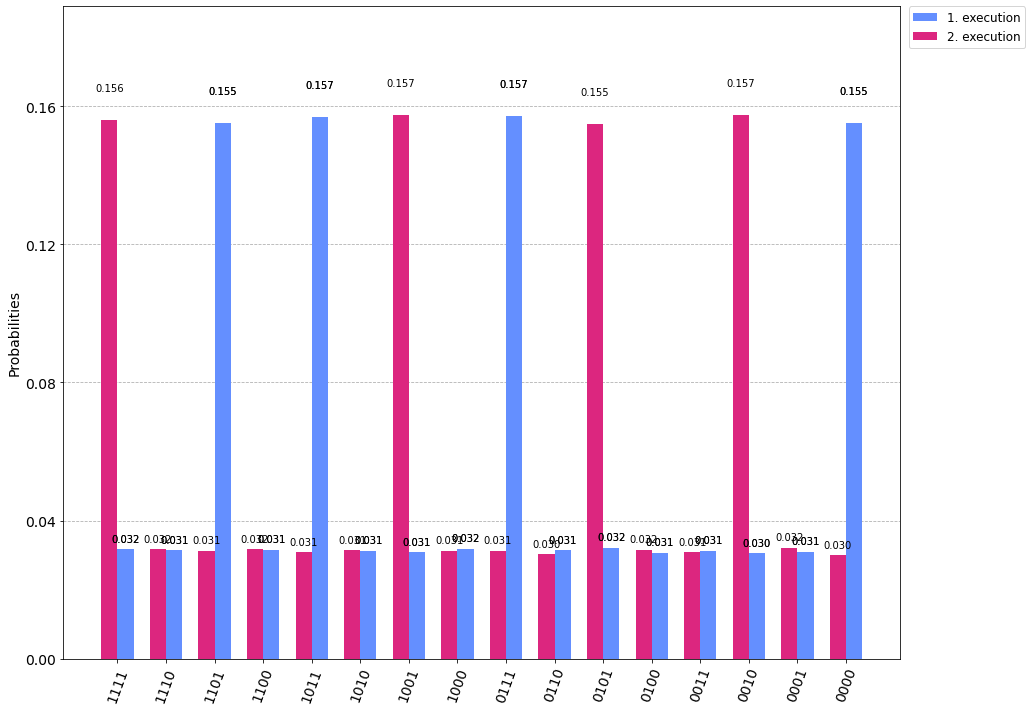

In [24]:
legend = [str(i + 1) + '. execution' for i in range(len(solution_counts))]
plot_histogram(solution_counts, legend=legend, sort='desc', figsize=(15,12))

In [26]:
for counts in solution_counts:
    sorted_counts = dict(sorted(counts.items(), key = lambda item: item[1], reverse=True))
    counts_iterator = iter(sorted_counts)
    print("Possible solution to Kakuro puzzle: ")
    for i in range(query_qubits):
        b = next(counts_iterator)
        (i, j) = state_to_variables(b)
        #print(i,j)
        print("x_" + str(i) + " = " + str(j))
    print()
    

Possible solution to Kakuro puzzle: 
x_1 = 3
x_2 = 3
x_3 = 1
x_0 = 0

Possible solution to Kakuro puzzle: 
x_2 = 1
x_0 = 2
x_3 = 3
x_1 = 1



## Solution proposal 2: Apply idea from Qiskit documentation

## Solution proposal 3: Apply ideas from paper Grover Adaptive Search for Constrained Polynomial Binary Optimization

### Encode constraints as QUBO

### Solve QUBO with Grover search

## Solution proposal 4: Quantum machine learning – again